In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit

In [ ]:

%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])


In [3]:
Bx = a.twbox[0].bx
By = a.twbox[0].by
Bz = a.twbox[0].bz

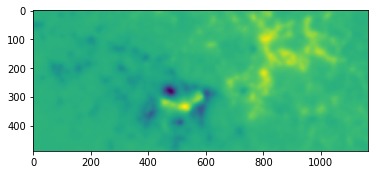

In [4]:
plt.imshow(a.twbox[0].bz[10,:,:])

In [5]:
vec = np.array([1.01,2.01,5.01])
vec[vec<=0]=1e-9
vec[vec>=Bx.shape]=(np.array(Bx.shape)-1e-9)[vec>=Bx.shape]

In [6]:
#trilerp(Bx,By,Bz,vec)

In [23]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy
a = numpy.random.randn(4,4)

a = a.astype(numpy.float32)

a_gpu = cuda.mem_alloc(a.nbytes)

cuda.memcpy_htod(a_gpu, a)

traceFunc_file = open("TraceBline.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read())
print('compiling kernel')
traceFunc_GPU = traceFunc.get_function("TraceBline")


In [ ]:

func(a_gpu, block=(8,4,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)
print(a_doubled)
print(a)

In [16]:

func = mod.get_function("doublify")

func(a_gpu, block=(16,4,1),grid=(1,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)
print(a_doubled)
print(a)

[[ 17.810139   18.773417  -41.745716    6.719679 ]
 [ 35.403587   15.222438   36.800003  -24.507534 ]
 [-74.535995   -2.5388143  -8.943554  -80.29178  ]
 [ -9.435086  -25.655186    9.932698  -34.86047  ]]
[[ 0.55656683  0.58666927 -1.3045536   0.20998996]
 [ 1.1063621   0.47570118  1.1500001  -0.76586044]
 [-2.3292499  -0.07933795 -0.27948606 -2.509118  ]
 [-0.29484645 -0.80172455  0.31039682 -1.0893897 ]]


In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(xx,yy,zz)